In [1]:
from glob import glob
import rasterio
from xarray import open_mfdataset
from warnings import filterwarnings
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import pandas as pd
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
%matplotlib inline
import math
filterwarnings('ignore')

In [2]:
# month_range = {
#     'jan':(1,31),
#     'april':(91,120),
#     'july':(182,212)
# }

month_range = {
	'jan':(1,31),
	'feb':(32,59),
	'march':(60, 90),
	'april':(91, 120),
	'may':(121,151),
	'june':(152,181),
	'july':(182, 212),
	'august':(213, 243),
	'sept':(244,273),
    'oct':(274, 304),
    'nov':(305, 334),
    'dec':(335, 365)

}

month_to_num_days = {'jan':31,
                     'feb':28,
                     'march':31,
                    'april':30,
                     'may':31,
                     'june':30,
                    'july':31,
                    'august':31,
                    'sept':30,
                    'oct':31,
                    'nov':30,
                    'dec':31}

In [3]:
grid_num = {
    '36km':1,
    '9km':16,
    '3km':144,
    '1km':1296
}

In [4]:
def days_missing_cyg_v3(month):
    lower_day, upper_day = month_range[month]
    j = lower_day
    for i in cygnss_day_nums[(cygnss_day_nums >= lower_day) & (cygnss_day_nums <= upper_day)] :
        while(j!=i):
            print(month, j-lower_day + 1)   
            j += 1
            continue
        j = j+1

In [5]:
def days_missing_l3_sm(month):
    lower_day, upper_day = month_range[month]
    for i in range(lower_day, upper_day+1):
        if np.isnan(global_sm[i-1][l3_lat][l3_lon]):
            print(month, i-lower_day+1)

In [6]:
# This function is wrong
def days_missing_smap(month):
    lower_day, upper_day = month_range[month]
    for i in range(lower_day, upper_day+1):
        if np.isnan(smap_comp_arr[i-lower_day]):
            print(month, i-lower_day+1)

In [7]:
def get_smap(month, grid_res):  
    lower_day, upper_day = month_range[month]
    SMAP = np.empty((month_to_num_days[month], grid_num[grid_res]))
    SMAP[:] = np.NaN
    smap_data_path = 'C:/Cygnss/smap/'+grid_res+'/smap_sm_9km_2019*.tif'
    smap_2019_files_list = glob(smap_data_path)
    smap_month_list = [x for x in smap_2019_files_list if ((int(x[-7:-4])>=lower_day) & (int(x[-7:-4])<=upper_day))]
    
    for i in range(len(smap_month_list)):
        smap = rasterio.open(smap_month_list[i])
        smap_1 = smap.read(1).astype('float64')
        smap_2 = smap.read(2).astype('float64')
        smap_avg = np.nanmean(np.array([smap_1, smap_2]), axis = 0)
        
        smap_avg_reordered = smap_avg[[3, 2, 1, 0]]

        smap_avg_flatten = smap_avg_reordered.flatten()
        SMAP[i,:] = smap_avg_flatten

    SMAP = np.nanmean(SMAP, axis = 1)    
    return list(SMAP)

In [8]:
example_d = "../level3/2019/*/_ucar_cu_cygnss_sm_v1_2019_*.nc"
example_f = sorted(glob(example_d))

# There should be 365 nc files. Print the first five:
len(example_f), example_f[:5]

(365,
 ['../level3/2019\\001\\_ucar_cu_cygnss_sm_v1_2019_001.nc',
  '../level3/2019\\002\\_ucar_cu_cygnss_sm_v1_2019_002.nc',
  '../level3/2019\\003\\_ucar_cu_cygnss_sm_v1_2019_003.nc',
  '../level3/2019\\004\\_ucar_cu_cygnss_sm_v1_2019_004.nc',
  '../level3/2019\\005\\_ucar_cu_cygnss_sm_v1_2019_005.nc'])

In [9]:
xds = open_mfdataset(example_f, combine="by_coords", concat_dim="time", parallel=True)

In [10]:
latitudes = xds['latitude'].values
longitudes = xds['longitude'].values
centre_lat = 30.311826
centre_lon = -98.775934
global_sm = xds['SM_daily'].values

In [11]:
l3_lat = 228
l3_lon = 97

In [12]:
cygnss_sm_df = pd.read_csv('../report/ML/cygnss_sm_all_months.csv')
cygnss_daily_sm = cygnss_sm_df.groupby(['day_num']).mean()['cygnss_sm'].to_numpy()

cygnss_day_nums = set(cygnss_sm_df['day_num'])
cygnss_day_nums = np.array(list(cygnss_day_nums))

In [15]:
# month = 'june'
# days_missing_smap(month)
# print('\n')
# days_missing_l3_sm(month)

In [16]:
cygnss_day_indices = list(cygnss_day_nums - 1)

In [17]:
# Get L3 sm values for days which have CYGNSS data
l3_sm = []
for i in cygnss_day_nums:
    l3_sm.append((global_sm[i-1][l3_lat][l3_lon]))
l3_daily_sm = np.array(l3_sm)

In [18]:
l3_bool = ~np.isnan(l3_daily_sm)

In [19]:
smap_jan = get_smap('jan', '9km')
smap_feb = get_smap('feb', '9km')
smap_march = get_smap('march', '9km')
smap_april = get_smap('april', '9km')
smap_may = get_smap('may', '9km')
smap_june = get_smap('june', '9km')
smap_july = get_smap('july', '9km')
smap_august = get_smap('august', '9km')
smap_sept = get_smap('sept', '9km')
smap_oct = get_smap('oct', '9km')
smap_nov = get_smap('nov', '9km')
smap_dec = get_smap('dec', '9km')

In [20]:
smap_july

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 0.13736689928919077,
 0.1279877454508096,
 nan,
 0.12380583491176367,
 0.1281351032666862,
 nan,
 0.12249604426324368,
 nan]

In [21]:
smap_comp = smap_jan + smap_feb +smap_march+ smap_april + smap_may + smap_june + smap_july + smap_august + smap_sept + smap_oct + smap_nov + smap_dec
smap_comp_arr = np.array(smap_comp)

In [40]:
smap_comp_arr

array([0.25575782,        nan, 0.28914485,        nan, 0.2769668 ,
       0.27033786,        nan, 0.25666145, 0.24976999,        nan,
       0.24811612,        nan, 0.26918138, 0.25784123,        nan,
       0.245826  , 0.2590032 ,        nan, 0.24630974,        nan,
       0.22892833, 0.2179666 ,        nan, 0.21530106, 0.20411375,
              nan, 0.26710945,        nan, 0.26238307, 0.22982193,
              nan, 0.21087409, 0.23221231,        nan, 0.23040034,
              nan, 0.22466526, 0.22014382,        nan, 0.22636375,
       0.23278348,        nan, 0.24289402,        nan, 0.22638176,
       0.22393687,        nan, 0.20599898, 0.19588387,        nan,
       0.20066123,        nan, 0.18892948, 0.19102656,        nan,
       0.17899728, 0.17416848,        nan, 0.19297078,        nan,
       0.2057828 , 0.21024473,        nan, 0.20171583, 0.18671487,
              nan, 0.18128635,        nan, 0.18161012, 0.16523592,
              nan, 0.26339574, 0.21528093,        nan, 0.18907

In [22]:
smap_daily_sm = smap_comp_arr[cygnss_day_indices]
smap_bool = ~np.isnan(smap_daily_sm)

In [23]:
def get_txson_monthly(month, grid_res):
    txson_path = 'C:/Cygnss/TxSON_v1_3/TxSON_v1_3/TxSON_upscaled/txson_' + month + '_voronoi_'+ grid_res + '.mat'
    txson = scipy.io.loadmat(txson_path)
    txson_sm = txson['SWCv'][:,:,0]
    return txson_sm

In [24]:
def avg_txson_daily(month, txson):
    txson_values = []
    num_days = month_to_num_days[month]
    month_days = np.arange(num_days)
    for day in month_days:
        lower = (day)*24
        upper = lower+24
        txson_values.append(np.nanmean(np.nanmean(txson[lower:upper,:], axis = 0)))
    return txson_values

In [25]:
txson_jan = get_txson_monthly('jan', '9km')
txson_feb = get_txson_monthly('feb', '9km')
txson_march = get_txson_monthly('march', '9km')
txson_apr = get_txson_monthly('april', '9km')
txson_may = get_txson_monthly('may', '9km')
txson_june = get_txson_monthly('june', '9km')
txson_july = get_txson_monthly('july', '9km')
txson_august = get_txson_monthly('august', '9km')
txson_sept = get_txson_monthly('sept', '9km')
txson_oct = get_txson_monthly('oct', '9km')
txson_nov = get_txson_monthly('nov', '9km')
txson_dec = get_txson_monthly('dec', '9km')

txson_daily_jan = avg_txson_daily('jan', txson_jan)
txson_daily_feb = avg_txson_daily('feb', txson_feb)
txson_daily_march = avg_txson_daily('march', txson_march)
txson_daily_apr = avg_txson_daily('april', txson_apr)
txson_daily_may = avg_txson_daily('may', txson_may)
txson_daily_june = avg_txson_daily('june', txson_june)
txson_daily_july = avg_txson_daily('july', txson_july)
txson_daily_august = avg_txson_daily('august', txson_august)
txson_daily_sept = avg_txson_daily('sept', txson_sept)
txson_daily_oct = avg_txson_daily('oct', txson_oct)
txson_daily_nov = avg_txson_daily('nov', txson_nov)
txson_daily_dec = avg_txson_daily('dec', txson_dec)

In [26]:
txson_comp = txson_daily_jan + txson_daily_feb + txson_daily_march + txson_daily_apr + txson_daily_may + txson_daily_june + txson_daily_july + txson_daily_august + txson_daily_sept + txson_daily_oct + txson_daily_nov + txson_daily_dec 

In [27]:
txson_daily_sm = np.array(txson_comp)
txson_daily_sm = txson_daily_sm[cygnss_day_indices]

In [28]:
cygnss_sm = cygnss_daily_sm[l3_bool&smap_bool]
txson_sm = txson_daily_sm[l3_bool&smap_bool]
l3_sm = l3_daily_sm[l3_bool&smap_bool]
smap_sm = smap_daily_sm[l3_bool&smap_bool]

In [29]:
scat_x = np.array(cygnss_day_indices)[l3_bool&smap_bool]

In [30]:
month_ticks = [month_range['jan'][0],month_range['feb'][0],month_range['march'][0],month_range['april'][0],month_range['may'][0],month_range['june'][0],month_range['july'][0],month_range['august'][0], month_range['sept'][0], month_range['oct'][0], month_range['nov'][0], month_range['dec'][0]]

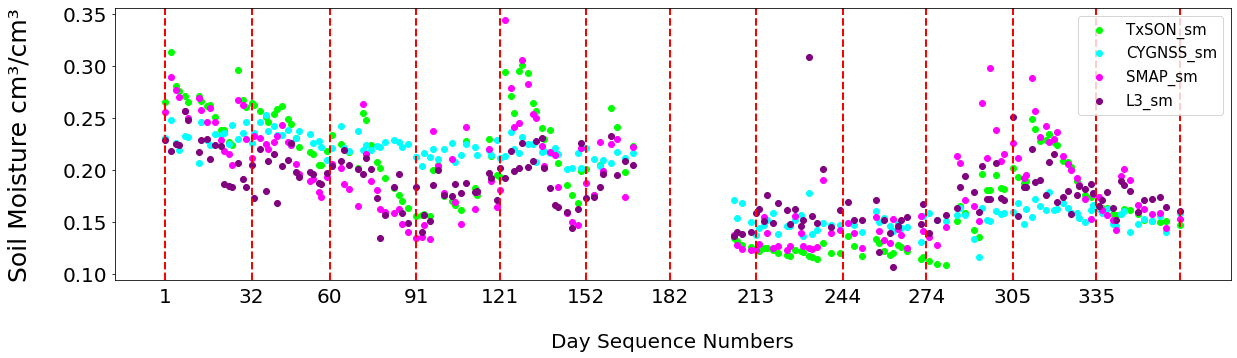

In [31]:
fig, ax = plt.subplots(figsize = (20,5))

ax.scatter(scat_x+1, txson_sm, c = 'lime',label = 'TxSON_sm')
ax.scatter(scat_x+1, cygnss_sm, c = 'cyan',label = 'CYGNSS_sm')
ax.scatter(scat_x+1, smap_sm, c = 'magenta',label = 'SMAP_sm')
ax.scatter(scat_x+1, l3_sm, c = 'purple',label = 'L3_sm', marker = 'o')


# ax.set_xlabel('Day Number')
ax.set_ylabel('Soil Moisture cm\u00b3/cm\u00b3\n')
ax.set_xlabel('\nDay Sequence Numbers')
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
# # plt.xticks(np.arange(min(data.index), max(data.index), 20))
# plt.xticks(np.arange(1,78))
# plt.xticks(scat_x+1)
plt.xticks(month_ticks)
ax.legend(prop = {'size':15})
lw = 2
plt.axvline(x=month_range['jan'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['feb'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['march'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['april'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['may'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['june'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['july'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['august'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['sept'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['oct'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['nov'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['dec'][0], linestyle = '--', linewidth = lw, color = 'red')
plt.axvline(x=month_range['dec'][1], linestyle = '--', linewidth = lw, color = 'red')

# plt.tick_params(axis = "x", which = "both", length = 6, width = 2, bottom = False, top = False)
plt.tick_params(axis = "x", which = "both", bottom = False, top = False)
plt.savefig('C:/Cygnss/report/figures/scatter_daily_36km_all_months.jpg')
plt.show()

In [32]:
np.round(pd.DataFrame({'TxSON_sm':txson_sm,'SMAP_sm': smap_sm, 'CYGNSS_sm':cygnss_sm, 'L3_sm': l3_sm}).corr(),3)

,TxSON_sm,SMAP_sm,CYGNSS_sm,L3_sm
TxSON_sm,1.000,0.886,0.763,0.688
SMAP_sm,0.886,1.000,0.519,0.653
CYGNSS_sm,0.763,0.519,1.000,0.522
L3_sm,0.688,0.653,0.522,1.000


In [33]:
np.round(math.sqrt(mean_squared_error(cygnss_sm, txson_sm)),3)

0.034

In [34]:
np.round(math.sqrt(mean_squared_error(l3_sm, txson_sm)),3)

0.04

In [241]:
np.round(math.sqrt(mean_squared_error(smap_sm, txson_sm)),3)

0.024

In [35]:
np.round(math.sqrt(mean_squared_error(cygnss_sm, smap_sm)),3)

0.042

In [37]:
np.round(math.sqrt(mean_squared_error(l3_sm, smap_sm)),3)

0.037

In [255]:
cygnss_day_nums.size

310

In [257]:
cygnss_sm.size

173

In [258]:
np.sum(l3_bool)

304

In [260]:
np.sum(smap_bool)

176

In [41]:
cygnss_sm.size

173